In [1]:
from radpy.stellar import *
from radpy.datareadandformat import *
from radpy.plotting import plot_v2_fit
from radpy.LDfitting import initial_LDfit, run_LDfit
from radpy.UDfitting import initial_UDfit, run_UDfit, udfit_values

In [2]:
def check_multidatasets(fitsfile, verbose = False):
    count = 0
    for i, hdu in enumerate(fitsfile):
        name = 'OI_VIS2'
        if hdu.name == name:
            if hdu.ver:
                count +=1
    if verbose:
        print("Nights:", count)
    return count

def unpack_multidatasets(fitsfile, count, verbose = False):
    if count > 1:
        v2_list = []
        dv2_list = []
        uc_list = []
        vc_list = []
        mjd_list = []
        time_list = []
        wl_list = []
        band_list = []
        if verbose:
            print("Multiple nights")
        for i in range(count):
            if verbose:
                print("Version:", i + 1)
            v2 = fitsfile["OI_VIS2", i + 1].data["VIS2DATA"]
            dv2 = fitsfile["OI_VIS2", i + 1].data["VIS2ERR"]
            ucoord = fitsfile["OI_VIS2", i + 1].data["UCOORD"]
            vcoord = fitsfile["OI_VIS2", i + 1].data["VCOORD"]
            mjd = fitsfile["OI_VIS2", i + 1].data["MJD"]
            time = fitsfile["OI_VIS2", i + 1].data["TIME"]
            wl = fitsfile["OI_WAVELENGTH", i + 1].data["EFF_WAVE"]
            band = fitsfile["OI_WAVELENGTH", i + 1].data["EFF_BAND"]

            wll = [wl.tolist() for _ in range(len(v2))]
            bandl = [band.tolist() for _ in range(len(v2))]

            v2_list.append(v2)
            dv2_list.append(dv2)
            uc_list.append(ucoord)
            vc_list.append(vcoord)
            mjd_list.append(mjd)
            time_list.append(time)
            wl_list.append(wll)
            band_list.append(bandl)
        pd.set_option('display.float_format', '{:.12f}'.format)
        df = pd.DataFrame({'MJD': mjd_list, 'Time': time_list, 'V2': v2_list, 'V2_err': dv2_list,
                           'Eff_wave[m]': wl_list, 'Eff_band[m]': band_list, 'UCOORD[m]': uc_list,
                           'VCOORD[m]': vc_list})
        df_e = df.apply(pd.Series.explode)
        return df_e
    else:
        if verbose:
            print("Only one night.")
        v2 = fitsfile["OI_VIS2"].data["VIS2DATA"]
        dv2 = fitsfile["OI_VIS2"].data["VIS2ERR"]
        ucoord = fitsfile["OI_VIS2"].data["UCOORD"]
        vcoord = fitsfile["OI_VIS2"].data["VCOORD"]
        mjd = fitsfile["OI_VIS2"].data["MJD"]
        time = fitsfile["OI_VIS2"].data["TIME"]
        wl = fitsfile["OI_WAVELENGTH"].data["EFF_WAVE"]
        band = fitsfile["OI_WAVELENGTH"].data["EFF_BAND"]

        wl_list = [wl.tolist() for _ in range(len(v2))]
        band_list = [band.tolist() for _ in range(len(v2))]

        pd.set_option('display.float_format', '{:.12f}'.format)
        df = pd.DataFrame({'MJD': mjd, 'Time': time, 'V2': v2.tolist(), 'V2_err': dv2.tolist(),
                           'Eff_wave[m]': wl_list, 'Eff_band[m]': band_list, 'UCOORD[m]': ucoord, 'VCOORD[m]': vcoord})

        return df


def oifits_to_pandas(filename, inst_name):
    # Reads in an oifits file and converts into a pandas dataframe with the necessary information needed for RADPy
    # Extracts the following data:
    #   V2, dv2, ucoord, vcoord, mjd, time, effective wavelength, and effective bandwidth
    # Converts the wavelengths and bandwidth arrays into lists of lists to match the V2 and V2err lists
    # creates a dataframe
    # Sorts the dataframe by MJD and then assigns a bracket number based on the date groupings
    # Explodes the dataframe by extracting out each list for V2, V2_err, wavelength, and bandwidth
    # returns the exploded, sorted, and bracket labeled df

    data = fits.open(filename)
    count = check_multidatasets(data)
    new_df = unpack_multidatasets(data,count)
    sorted_df = brackets(new_df, inst_name)
    sorted_df['zipped'] = sorted_df.apply(
        lambda row: list(zip(row['V2'], row['V2_err'], row['Eff_wave[m]'], row['Eff_band[m]'])), axis=1)
    df_exploded = sorted_df.explode('zipped').reset_index(drop=True)
    df_exploded[['V2', 'V2_err', 'Eff_wave[m]', 'Eff_band[m]']] = pd.DataFrame(df_exploded['zipped'].tolist(),
                                                                               index=df_exploded.index)
    df_exploded = df_exploded.drop(columns='zipped')
    df_exploded['Instrument'] = [inst_name] * len(df_exploded)

    return df_exploded

def filename_extension(filename, inst_name, verbose=False, debug = False):
    #########################################################################
    # Function: filename_extension                                          #
    # Inputs: filename -> name of data file                                 #
    #         inst_name -> Instrument identifier                            #
    #                      C - Classic                                      #
    #                      P - PAVO                                         #
    #                      V - VEGA                                         #
    #                      M - MIRCX                                        #
    #                      MY - MYSTIC                                      #
    #                      S - SPICA                                        #
    #         verbose -> default is False, if true, allows print statements #
    # Outputs: data frame of the data with the instrument added as a column #
    # What it does:                                                         #
    #         1. Checks what format the file is in                          #
    #         If .csv:                                                      #
    #            2a. Uses pandas.read_csv to read in the file               #
    #            3a. Adds the Instrument column                             #
    #         If .txt:                                                      #
    #            2b. Opens the file and reads in the first line             #
    #            3b. Checks what delimiter the file is using                #
    #            4b. Reads in the file                                      #
    #            5b. Adds the instrument column                             #
    #         If .oifits or .fits:                                          #
    #            2c. uses the oifits_to_pandas function                     #
    #         Returns the dataframe, and number of brackets                 #
    #########################################################################

    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
        df['Instrument'] = [inst_name] * len(df)
        sorted_df = brackets(df, inst_name)
        num_brackets = sorted_df['Bracket'].max()
        print('Number of brackets:', num_brackets)
        return sorted_df, num_brackets
        # return sorted_df
    elif filename.endswith('.txt'):
        header = None
        data_start = 0
        with open(filename, 'r') as f:
            lines = f.readlines()
        for i, line in enumerate(lines):
            if line.strip().startswith('#'):
                # Remove '#' and newline, then split by pipe (or whatever header delimiter you expect)
                header = [col.strip() for col in line.strip()[1:].split('|')]
                data_start = i + 1
                if debug:
                    print(f"Header detected: {header}")
                break

        # Read the data lines (skip header and comments)
        # Drop empty lines and comments
        data_lines = [l for l in lines[data_start:] if l.strip() and not l.strip().startswith('#')]

        # Save to a temp string buffer for pandas
        from io import StringIO
        data_str = ''.join(data_lines)
        df = pd.read_csv(StringIO(data_str), sep=r'\s+', header=None, engine='python')
        if header and len(header) == df.shape[1]:
            df.columns = header
        df['Instrument'] = [inst_name] * len(df)
        sorted_df = brackets(df, inst_name)
        num_brackets = sorted_df['Bracket'].max()
        if verbose:
            print('Number of brackets:', num_brackets)
        return sorted_df, num_brackets


    elif filename.endswith('.oifits') or filename.endswith('.fits'):
        df = oifits_to_pandas(filename, inst_name)
        num_brackets = df['Bracket'].max()
        print('Number of brackets:', num_brackets)
        return df, num_brackets
        # return df

    else:
        header = None
        data_start = 0
        with open(filename, "r") as f:
            lines = f.readlines()
        for i, line in enumerate(lines):
            if line.strip().startswith('#'):
                # Remove '#' and newline, then split by pipe (or whatever header delimiter you expect)
                header = [col.strip() for col in line.strip()[1:].split('|')]
                data_start = i + 1
            if debug:
                print(f"Header detected: {header}")
            break

        # Read the data lines (skip header and comments)
        # Drop empty lines and comments
        data_lines = [l for l in lines[data_start:] if l.strip() and not l.strip().startswith('#')]

        # Save to a temp string buffer for pandas
        from io import StringIO
        data_str = ''.join(data_lines)
        df = pd.read_csv(StringIO(data_str), sep=r'\s+', header=None, engine='python')
        if header and len(header) == df.shape[1]:
            df.columns = header
        df['Instrument'] = [inst_name] * len(df)
        sorted_df = brackets(df, inst_name)
        num_brackets = sorted_df['Bracket'].max()
        if verbose:
            print('Number of brackets:', num_brackets)
        return sorted_df, num_brackets

def brackets(df, instrument):
    # bracket generator
    # PAVO brackets are assigned via same baseline
    # Classic has no brackets
    # MIRCX/MYSTIC/SPICA are by MJD
    # Vega is uncertain for now but will be date im fairly certain
    if instrument == 'M' or instrument == 'm':
        pd.set_option('display.float_format', '{:.12f}'.format)
        sorted_df = df.sort_values(by='MJD')
        sorted_df['Bracket'] = sorted_df.groupby('MJD').ngroup() + 1
        return sorted_df
    if instrument == 'P' or instrument == 'p':
        pd.set_option('display.float_format', '{:.12f}'.format)
        sorted_df = df.sort_values(by='U(meters)')
        sorted_df['Bracket'] = sorted_df.groupby('U(meters)').ngroup() + 1
        return sorted_df
    if instrument == 'C' or instrument == 'c':
        pd.set_option('display.float_format', '{:.12f}'.format)
        df['Bracket'] = [1] * len(df)
        return df
    if instrument == 'S' or instrument == 's':
        pd.set_option('display.float_format', '{:.12f}'.format)
        sorted_df = df.sort_values(by='UCOORD[m]')
        sorted_df['Bracket'] = sorted_df.groupby('UCOORD[m]').ngroup() + 1
        return sorted_df
    if instrument == 'My' or instrument == 'my':
        pd.set_option('display.float_format', '{:.12f}'.format)
        sorted_df = df.sort_values(by='MJD')
        sorted_df['Bracket'] = sorted_df.groupby('MJD').ngroup() + 1
        return sorted_df
    if instrument == 'V' or instrument == 'v':
        pd.set_option('display.float_format', '{:.12f}'.format)
        sorted_df = df.sort_values(by='MJD')
        sorted_df['Bracket'] = sorted_df.groupby('MJD').ngroup() + 1
        return sorted_df


def combined(*dfs, fulldf=False):
    # combines the data into one big data frame if needed

    b = pd.concat([df['B'] for df in dfs], ignore_index=True)
    v2 = pd.concat([df['V2'] for df in dfs], ignore_index=True)
    dv2 = pd.concat([df['dV2'] for df in dfs], ignore_index=True)
    wave = pd.concat([df['Wave'] for df in dfs], ignore_index=True)
    band = pd.concat([df['Band'] for df in dfs], ignore_index=True)
    brack = pd.concat([df['Bracket'] for df in dfs], ignore_index=True)
    inst = pd.concat([df['Instrument'] for df in dfs], ignore_index=True)


    if not fulldf:
        return b, v2, dv2, wave, band, brack, inst

    if fulldf:
        return pd.DataFrame({
            'B': b, 'V2': v2, 'dV2': dv2,
            'Wave': wave, 'Band': band,
            'Bracket': brack, 'Instrument': inst})


class InterferometryData:
    def __init__(self, df, instrument_code):
        self.raw = df.copy()
        self.instrument = instrument_code.lower()
        self.cleaned = None
        self.process()

    def process(self):
        raise NotImplementedError("Subclasses must implement the .process() method")

    def make_df(self, LDC=None):
        n = len(self.B)

        if LDC is None:
            ldc_col = [None] * n
        elif np.isscalar(LDC):
            ldc_col = [LDC] * n
        elif isinstance(LDC, (list, np.ndarray, pd.Series)) and len(LDC) == n:
            ldc_col = LDC
        else:
            raise ValueError(f"LDC must be None, a scalar, or a list/array of length {n}, got {LDC}.")

        return pd.DataFrame({
            "B": self.B,
            "V2": self.V2,
            "dV2": self.dV2,
            "Wave": self.Wave,
            "LDC": ldc_col,
            "Band": self.Band,
            "Bracket": self.Bracket,
            "Instrument": [self.instrument] * len(self.B)

        })

    def make_ldmcdf(self, LDC):
        # spf = self.B / self.Wave

        return pd.DataFrame({
            # "Spf":spf,
            "B": self.B,
            "V2": self.V2,
            "dV2": self.dV2,
            "LDC": LDC,
            "Bracket": self.Bracket,
            "Instrument": [self.instrument] * len(self.V2)
        })


class PavoData(InterferometryData):
    def __init__(self, df):
        super().__init__(df, instrument_code='p')

    def process(self):
        df = self.raw.dropna(subset=['V2', 'sigma_V2'])
        self.cleaned = df

        self.V2 = df['V2']
        self.dV2 = df['sigma_V2']
        self.U = df['U(meters)']
        self.V = df['V(meters)']
        self.B = np.sqrt(self.U ** 2 + self.V ** 2)
        self.Wave = self.B / df['B/lambda']
        self.Band = pd.Series(np.full(len(df), 5e-9))  # 5 nm
        self.Bracket = df['Bracket']


class ClassicData(InterferometryData):
    def __init__(self, df):
        super().__init__(df, instrument_code='c')

    def process(self):
        df = self.raw.dropna(subset=['Vis', 'Vis_e'])  # clean NaNs
        self.cleaned = df
        v = df['Vis']
        dv = df['Vis_e']

        self.B = df['B']
        self.V2 = v ** 2
        self.dV2 = self.V2 * np.sqrt(2 * (dv / v) ** 2)
        self.Wave = pd.Series(np.full(len(self.B), 2.1329e-6))  # meters
        self.Band = pd.Series(np.full(len(self.B), 5e-9))  # meters (5 nm)
        self.Bracket = df['Bracket']


class VegaData(InterferometryData):
    def __init__(self, df):
        super().__init__(df, instrument_code='v')

    def process(self):
        df = self.raw.dropna(subset=['V2', 'sigma_sys', 'sigma_stat'])  # clean NaNs
        self.cleaned = df
        dv2_sys = df['sigma_sys']
        dv2_stat = df['sigma_stat']

        self.B = df['Baseline length']
        self.V2 = df['V2']
        self.dV2 = np.sqrt((dv2_sys ** 2) + (dv2_stat) ** 2)
        self.Wave = df['lambda'] * 1e-9
        self.Band = pd.Series(np.full(len(df), 5e-9))
        self.Bracket = df['Bracket']


class MircxData(InterferometryData):
    def __init__(self, df):
        super().__init__(df, instrument_code='m')

    def process(self):
        df = self.raw.dropna(subset=['V2', 'V2_err'])  # clean NaNs
        self.cleaned = df

        ucoord = (df['UCOORD[m]'].values).astype('float')
        vcoord = (df['VCOORD[m]'].values).astype('float')
        self.B = np.sqrt((ucoord ** 2) + (vcoord ** 2))
        self.V2 = df['V2']
        self.dV2 = df['V2_err']
        self.Wave = df['Eff_wave[m]']
        self.Band = df['Eff_band[m]']
        self.Bracket = df['Bracket']

class MysticData(InterferometryData):
    def __init__(self, df):
        super().__init__(df, instrument_code='my')

    def process(self):
        df = self.raw.dropna(subset=['V2', 'V2_err'])  # clean NaNs
        self.cleaned = df

        ucoord = (df['UCOORD[m]'].values).astype('float')
        vcoord = (df['VCOORD[m]'].values).astype('float')
        self.B = np.sqrt((ucoord ** 2) + (vcoord ** 2))
        self.V2 = df['V2']
        self.dV2 = df['V2_err']
        self.Wave = df['Eff_wave[m]']
        self.Band = df['Eff_band[m]']
        self.Bracket = df['Bracket']

In [3]:

from radpy.plotting import bin_data
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from radpy.UDfitting import UDV2
from radpy.LDfitting import V2
plt.rcParams['text.usetex'] = True
def plot_v2_fit(data_dict, star, line_spf=None, ldc_band=None, eq_text=False,
                datasets_to_plot=None, plot_ldmodel=False, plot_udmodel=False,
                to_bin=None, title=None, set_axis = None, savefig=None, show=True):
    ###########################################################################
    # Function: plot_v2_fit                                                   #
    # Inputs: data_dict -> dict of InterferometryData objects,                #
    #                    e.g. {'pavo': pavo_obj, ...}                         #
    #         star-> star object with .theta and .ldc* attributes             #
    #                (ldcR, ldcK, etc.), and .V2(line_spf, theta, ldc)        #
    #         line_spf -> x values for model curve                            #
    #         ldc_band -> string (e.g. "ldcR", "ldcK") for which LDC          #
    #                     coefficient to use                                  #
    #         eq_text -> optional string for annotation                       #
    #         datasets_to_plot-> list of keys in data_dict to plot            #
    #                            (default: all)                               #
    #         plot_ldmodel-> bool, whether to plot the ld model curve         #
    #         plot_udmodel -> bool, whether to plot the ud model curve        #
    #         to_bin -> list of kets in data_dict to bin                      #
    #         set_axis -> sets the axis limits                                #
    #         title -> allows user to set a plot title                        #
    #         savefig-> filename to save, if desired                          #
    #         show-> whether to plt.show()                                    #
    # Outputs: the plot                                                       #
    # What it does:                                                           #
    #        1. Initializes plotting parameters                               #
    #        2. Checks to see what datasets the user wants plotted            #
    #        3. Defines dictionaries for each instrument and the marker,      #
    #           color, label, and alpha value for each one                    #
    #        4. Checks to see if set_axis has been assigned. If it has,       #
    #           sets the axis limits and adjusts line_spf accordingly. If     #
    #           not, sets line_spf to be max(spf) with padding                #
    #        Starts with the top plot                                         #
    #        5. For each data set, sets the keys for the color, marker, label #
    #           and alpha value                                               #
    #        6. Checks to see if the to_bin has been set                      #
    #        7. if to_bin has been set, plots the unbinned data for each      #
    #           data set, and then bins the data sets indicated then plots    #
    #           those                                                         #
    #        8. If to_bin has not been set, it plots the unbinned data        #
    #        9. For the model, if plot_ldmodel is set, pulls the ldtheta,     #
    #           error on the theta, and the ldcs and calculates the fits for  #
    #           the relevant filter                                           #
    #       10. Plots the model for the filter indicated                      #
    #       11. If eq_text is set, annotates the plot with the theta val      #
    #       12. If plot_udmodel is set, pulls the udtheta and error, and      #
    #           calculates the UD model and plots it                          #
    #       13. If eq_text is set, annotates the plot the theta val           #
    #       14. Checks to see how many datasets are being plotted. If more    #
    #           than 1, sets the legend. If not, does not plot legend.        #
    #       Bottom plot:                                                      #
    #       15. For each data set, it pulls the respective keys for the       #
    #           color, label, alpha, and marker for each instrument           #
    #       16. For each data set, checks to see if the to_bin value has been #
    #           set.                                                          #
    #       17. If plot_ldmodel has been set, it calculates the residuals for #
    #           the data and the model for the filter indicated.              #
    #       18. If to_bin has been set, it calculates the residuals for the   #
    #           binned data as well.                                          #
    #       19. If plot_udmodel has been set, it calculates the residuals for #
    #           the data and the ud model.                                    #
    #       20. If to_bin has been set, it calcualtes the residuals for the   #
    #           binned data as well.                                          #
    #       21. Plots the residuals for the unbinned (and binned if set)      #
    #       22. Saves fig if save_fig has been set                            #
    #       23. Shows fig if show has been set.                               #
    ###########################################################################
    plt.rcParams.update({'font.size': 18})
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [10, 3]}, sharex=True)

    if datasets_to_plot is None:
        datasets_to_plot = list(data_dict.keys())

    color_map = {
        'pavo': '#02ccfe',
        'classic': '#738595',
        'vega': '#5edc1f',
        'mircx': '#efc8ff',
        'mystic': '#ffcfdc',
        'spica': '#ff964f'
    }
    binned_color_map = {
        'pavo': '#030aa7',
        'classic': '#000000',
        'vega': '#028f1e',
        'mircx': '#7e1e9c',
        'mystic': '#ff028d',
        'spica': '#fe4b03'
    }
    marker_map = {
        'pavo': '.',
        'classic': 's',
        'vega': '^',
        'mircx': 'x',
        'mystic': '*',
        'spica': 'D'
    }
    label_map = {
        'pavo': r'$\rm PAVO$',
        'classic': r'$\rm Classic$',
        'vega': r'$\rm VEGA$',
        'mircx': r'$\rm MIRC-X$',
        'mystic': r'$\rm MYSTIC$',
        'spica': r'$\rm SPICA$'
    }
    alpha_map = {
        'pavo': 0.25,
        'classic': 0.25,
        'vega': 0.25,
        'mircx': 0.15,
        'mystic': 0.15,
        'spica': 0.15
    }

    if set_axis and line_spf is None:
        xmin = set_axis[0]
        xmax = set_axis[1]
        ymin = set_axis[2]
        ymax = set_axis[3]
        a0.set_xlim(xmin, xmax)
        a0.set_ylim(ymin, ymax)
        line_spf = np.linspace(0.00001, xmax, 1000)
    else:
        all_spf = []
        for key in datasets_to_plot:
            data = data_dict[key]
            spf = np.array(data.B) / np.array(data.Wave)
            all_spf.extend(spf)
        all_spf = np.array(all_spf)
        max_spf = np.max(all_spf)
        line_spf = np.linspace(0.00001, max_spf * 1.1, 1000)  # slight padding

    # --- Top: V2 ---
    for key in datasets_to_plot:
        data = data_dict[key]
        color = color_map.get(key, None)
        bin_color = binned_color_map.get(key, None)
        marker = marker_map.get(key, '.')
        label = label_map.get(key, key.capitalize())
        alpha = alpha_map.get(key, 0.5)
        spf = np.array(data.B) / np.array(data.Wave)

        is_binned = to_bin and key in to_bin
        # Always plot both, but only one gets the label
        if is_binned:
            # Plot unbinned points, no label
            a0.plot(spf, data.V2, linestyle='None', marker=marker, markersize=3, color=color, alpha=alpha)
            a0.errorbar(spf, data.V2, yerr=abs(data.dV2), fmt=marker, markersize=3, linestyle='None', linewidth=0.5,
                        color=color,
                        capsize=3, alpha=alpha)
            # Plot binned points, with label
            binned_spf, binned_v2, binned_dv2 = bin_data(spf, data.V2, data.dV2)
            a0.plot(binned_spf, binned_v2, linestyle='None', marker=marker, markersize=7, color=bin_color, label=label)
            a0.errorbar(binned_spf, binned_v2, yerr=abs(binned_dv2), fmt=marker, linestyle='None', markersize=7,
                        color=bin_color,
                        capsize=3)
        else:
            # Plot unbinned points, with label
            a0.plot(spf, data.V2, linestyle='None', marker=marker, markersize=3, color=color, alpha=alpha, label=label)
            a0.errorbar(spf, data.V2, yerr=abs(data.dV2), fmt=marker, markersize=3, linestyle='None', linewidth=0.5,
                        color=color,
                        capsize=3, alpha=alpha)
    # --- Model ---
    if plot_ldmodel:
        ldc_value = getattr(star, ldc_band, None)
        theta = getattr(star, "ldtheta", None)
        dtheta = getattr(star, "ldtheta_err", None)
        if ldc_value is not None and theta is not None:
            model_label = fr"$ \rm Model ({ldc_band.replace('ldc_', '').upper()})$"
            a0.plot(line_spf, V2(line_spf, theta, ldc_value), '--', color='black', label=model_label)
            if eq_text:
                eq1 = fr"$\theta_{{\rm LD}} = {round(theta, 3)} \pm {round(dtheta, 3)} \rm ~mas$"
                a0.text(0.05, 0.05, eq1, transform=a0.transAxes, color='black', fontsize=15)
        else:
            print(f"Warning: {ldc_band} or ldtheta not present for star, skipping model plot.")

    if plot_udmodel:
        theta = getattr(star, "udtheta", None)
        dtheta = getattr(star, "udtheta_err", None)
        if theta is not None:
            model_label = fr"$\rm Uniform~Disk~Model$"
            a0.plot(line_spf, UDV2(line_spf, theta), '--', color='black', label=model_label)
            if eq_text:
                eq1 = fr"$\theta_{{\rm UD}} = {round(theta, 3)} \pm {round(dtheta, 3)} \rm ~mas$"
                a0.text(0.05, 0.05, eq1, transform=a0.transAxes, color='black', fontsize=15)
        else:
            print(f"Warning: udtheta not present for star, skipping model plot.")

    if len(datasets_to_plot) > 1:
        a0.legend(fontsize=12)

    a0.set_ylabel(r'$V^2$', labelpad=17)
    a0.tick_params(axis='x', labelbottom=False)
    a0.xaxis.set_minor_locator(AutoMinorLocator())
    a0.yaxis.set_minor_locator(AutoMinorLocator())
    a0.set_title(title)

    # --- Bottom panel: Residuals ---
    for key in datasets_to_plot:
        data = data_dict[key]
        color = color_map.get(key, None)
        bin_color = binned_color_map.get(key, None)
        marker = marker_map.get(key, '.')
        alpha = alpha_map.get(key, 0.5)
        spf = np.array(data.B) / np.array(data.Wave)

        is_binned = to_bin and key in to_bin  # e.g. to_bin = ['pavo']

        # --- Model and Residuals for Unbinned ---
        if plot_ldmodel and ldc_value is not None and theta is not None:
            model_v2 = V2(spf, theta, ldc_value)
            residuals = np.array(data.V2) - model_v2
            a1.plot(spf, residuals, linestyle='None', marker=marker, markersize=3, color=color, alpha=alpha)
            a1.errorbar(spf, residuals, yerr=abs(data.dV2), fmt=marker, markersize=3, linestyle='None', linewidth=0.5,
                        color=color,
                        capsize=3, alpha=alpha)

            # --- Model and Residuals for Binned ---
            if is_binned:
                binned_spf, binned_v2, binned_dv2 = bin_data(spf, data.V2, data.dV2)
                model_binv2 = V2(binned_spf, theta, ldc_value)
                binned_res = binned_v2 - model_binv2
                a1.plot(binned_spf, binned_res, linestyle='None', marker=marker, markersize=7, color=bin_color)
                a1.errorbar(binned_spf, binned_res, yerr=abs(binned_dv2), fmt=marker, linestyle='None', markersize=7,
                            color=bin_color, capsize=3)

        # --- (Repeat similar for UD model if desired) ---
        if plot_udmodel and theta is not None:
            model_udv2 = UDV2(spf, theta)
            ud_res = np.array(data.V2) - model_udv2
            a1.plot(spf, ud_res, linestyle='None', marker=marker, markersize=3, color=color, alpha=alpha)
            a1.errorbar(spf, ud_res, yerr=abs(data.dV2), fmt=marker, markersize=3, linestyle='None', linewidth=0.5,
                        color=color, capsize=5,
                        alpha=alpha)

            if is_binned:
                binned_spf, binned_v2, binned_dv2 = bin_data(spf, data.V2, data.dV2)
                model_binudv2 = UDV2(binned_spf, theta)
                binned_udres = binned_v2 - model_binudv2
                a1.plot(binned_spf, binned_udres, linestyle='None', marker=marker, markersize=7, color=bin_color)
                a1.errorbar(binned_spf, binned_udres, yerr=abs(binned_dv2), fmt=marker, linestyle='None', markersize=7,
                            color=bin_color, capsize=3)

    a1.axhline(y=0, color='black', linestyle='--')
    a1.set_ylabel(r'$\rm Residual$', labelpad=3)
    plt.yticks([-.25, 0, 0.25])
    a1.set_ylim([-0.35, 0.35])
    a1.xaxis.set_minor_locator(AutoMinorLocator())
    a1.yaxis.set_minor_locator(AutoMinorLocator())

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.xlabel(r'$\rm Spatial$ $\rm frequency$ [$\rm rad^{-1}$]')

    if savefig:
        f.savefig(savefig, bbox_inches='tight')
    if show:
        plt.show()
    return f, (a0, a1)

In [4]:
import numpy as np
import pandas as pd
from lmfit import Model
import scipy.special as ss
from astropy.stats import mad_std
from radpy.stellar import temp
import warnings
warnings.filterwarnings("ignore", message="Using UFloat objects with std_dev==0 may give unexpected results.")
warnings.filterwarnings("ignore", message="DataFrameGroupBy.apply operated on the grouping columns")
#Uniform disk V2 equation
def UDV2(sf, theta):
    x = np.pi*sf*(theta/(206265*1000))
    vis = (2*ss.jv(1,x))/x
    return vis**2
##########################################################################################
#Uniform disk V2 equation with scaling factor added in
def scaledUDV2(sf, theta, V0):
    x = np.pi*sf*(theta/(206265*1000))
    vis = (V0**2)*(((2*ss.jv(1,x))/x)**2)
    return vis
##########################################################################################
# calculates chi squared and chi squared reduced
def chis(y, exp_y, yerr, dof):
    chisqr = np.sum(((y - exp_y) / (yerr)) ** 2)
    chisqr_red = chisqr / (len(y) - dof)
    return chisqr, chisqr_red


##########################################################################################
# Weighted average function
def weight_avg(df):
    x = df['V2']
    dx = df['dV2']
    weight = 1 / (dx ** 2)
    wavg = sum(weight * x) / sum(weight)
    dwavg = 1 / np.sqrt(sum(weight))
    return dwavg


##########################################################################################
# Random bracket function for bootstrapping
def random_bracket(df, num_of_brackets):
    ###########################################################################
    # Function: random_bracket                                                #
    # Inputs: df -> dataframe with spatial frequency, v2, v2_err, and bracket #
    #         num_of_brackets -> number of brackets in total you have         #
    # Outputs: spf_br -> the spatial frequencies randomized                   #
    #          v2_br -> the visibility squared randomized                     #
    #          dv2_br -> the error on the v2 randomized                       #
    #          wavgs -> weighted averages of the v2                           #
    # What it does:                                                           #
    #      1. sets the seed                                                   #
    #      2. picks a random number between 2 and the number of brackets      #
    #      3. Selects that many unique bracket labels at random               #
    #      4. Filters the dataframe down to only those with those specific    #
    #         bracket labels                                                  #
    #      5. Groups by the bracket labels                                    #
    #      6. Applies the weight average to the grouped data                  #
    #      7. Adds the weighted average as a column in the data frame         #
    #      8. Merges the groups into a new group for weighted average         #
    #         based on the bracket                                            #
    #      9. Splits up the dataframe into spatial frequency, v2, dv2, and    #
    #         wavg                                                            #
    #     10. Returns spatial frequency, v2, dv2, and wavg                    #
    ###########################################################################
    np.random.seed()
    xdata = []
    ydata = []
    dydata = []
    numbr = np.random.randint(2, num_of_brackets)
    # chatgpt wrote the next couple lines
    random_group_ids = df['Bracket'].drop_duplicates().sample(n=numbr).values

    # Filter the DataFrame for the selected groups
    random_groups = df[df['Bracket'].isin(random_group_ids)]

    grouped = random_groups.groupby('Bracket')

    # results = grouped.apply(weight_avg, include_group = False).reset_index()
    results = grouped.apply(weight_avg).reset_index()
    # Version-aware apply for future compatibility
    # pandas_major = int(pd.__version__.split('.')[0])
    # pandas_minor = int(pd.__version__.split('.')[1])
    # if pandas_major >= 2:
    #    results = grouped.apply(weight_avg, include_group=False).reset_index()
    # else:
    #    results = grouped.apply(weight_avg).reset_index()

    results.columns = ['Bracket', 'Wavg']
    random_groups_with_avg = random_groups.merge(results, on='Bracket')

    spf_br = random_groups_with_avg['Spf']  # spatial frequency in rad^-1
    v2_br = random_groups_with_avg['V2']  # Visibility squared
    dv2_br = random_groups_with_avg['dV2']
    wavgs = random_groups_with_avg['Wavg']

    return spf_br, v2_br, dv2_br, wavgs


##########################################################################################
# Percent difference function
def percent_diff(x1, x2, verbose=False):
    diff = (abs(x1 - x2) / ((x1 + x2) / 2)) * 100
    if verbose:
        print("Percent difference:", round(diff, 2), "%")
    return round(diff, 3)
##########################################################################################
def safe_theta_extraction(result):
    param = result.params['theta']
    value = param.value
    stderr = param.stderr
    if stderr is None or stderr == 0:
        return value, None
    else:
        uvar = result.uvars['theta']
        return uvar.n, uvar.s
##########################################################################################
def safe_thetaV0_extraction(result):
    tparam = result.params['theta']
    tvalue = tparam.value
    tstderr = tparam.stderr
    vparam = result.params['V0']
    vvalue = vparam.value
    vstderr = vparam.stderr
    if tstderr is None or tstderr == 0 or vstderr is None or vstderr == 0:
        return tvalue, None, vvalue, None
    else:
        uvar = result.uvars['theta']
        vvar = result.uvars['V0']
        return uvar.n, uvar.s, vvar.n, vvar.s
##########################################################################################
def initial_UDfit(spf, v2, dv2, theta_guess, star_params, v0_flag = False, verbose=False):
    #####################################################################
    # Function: initial_UDfit                                           #
    # Inputs: spf -> spatial frequency                                  #
    #         v2 -> visibilitity squared                                #
    #         dv2 -> error on the V2                                    #
    #         theta_guess -> initial guess for theta                    #
    #         star_params -> stellar class object                       #
    #         verbose -> if set to True, allows print statements        #
    #                    defaults to False                              #
    # Outputs: theta_ilm -> initial uniform disk diameter               #
    #          dtheta_ilm -> error on the diameter                      #
    #          chisqr_ilm -> chi squared reduced value                  #
    # What it does:                                                     #
    #        1. Initialized the model                                   #
    #        2. initializes the parameters                              #
    #        3. Fits for the UD diameter using lmfit                    #
    #           uses for the weights as 1/dv2                           #
    #        4. pulls out the theta, dtheta, and chi squared reduced    #
    #        5. updates the stellar object                              #
    #        6. Returns the theta, dtheta, and chi squared reduced      #
    #####################################################################
    if not v0_flag:
        #print("No scaling used")
        udmodel = Model(UDV2)
        udparams = udmodel.make_params(theta=theta_guess)
        ud_result = udmodel.fit(v2, udparams, sf=spf, weights=1 / (dv2), scale_covar=False)
        theta_ilm, dtheta_ilm = safe_theta_extraction(ud_result)

        chisqr_ilm = ud_result.redchi  # chi squared reduced of the fit
        if verbose:
            print('Initial fit with lmfit:')
            print(ud_result.fit_report())

        star_params.update(udthetai=round(theta_ilm,5), udthetai_err=round(dtheta_ilm,5))
        return (theta_ilm, dtheta_ilm, chisqr_ilm)
        
    if v0_flag:
        #print("Scaling used")
        udmodel = Model(scaledUDV2)
        udparams = udmodel.make_params(theta=theta_guess, V0 = 1.0)
        ud_result = udmodel.fit(v2, udparams, sf=spf, weights=1 / (dv2), scale_covar=False)
        theta_ilm, dtheta_ilm, v0_ilm, dv0_ilm = safe_thetaV0_extraction(ud_result)
        chisqr_ilm = ud_result.redchi  # chi squared reduced of the fit
        
        if verbose:
            print('Initial fit with lmfit:')
            print(ud_result.fit_report())

        star_params.update(udthetai=round(theta_ilm,5), udthetai_err=round(dtheta_ilm,5), udv0i = round(v0_ilm), udv0i_err = round(dv0_ilm))
        return (theta_ilm, dtheta_ilm, v0_ilm, dv0_ilm, chisqr_ilm) 

def make_df(B, v2, dv2, wave, band, brack, inst, fulldf=False):
    rand_wave = np.random.normal(wave, band)
    new_spf = B / rand_wave
    if not fulldf:
        return new_spf
    if fulldf:
        new_df = pd.DataFrame(np.column_stack((new_spf, v2, dv2, brack, inst)),
                              columns=['Spf', 'V2', 'dV2', 'Bracket', 'Instrument'])
        return new_df

def bootstrap(df, inst):
    ###########################################################
    # Function: bootstrap                                     #
    # Inputs: df -> the data dataframe                        #
    #         inst -> the intstrument                         #
    # Outputs: the new_df                                     #
    # What it does:                                           #
    #       1. If the instrument is set to c (Classic),       #
    #          samples the V2 on a normal distribution        #
    #          and creates a new dataframe with that.         #
    #       2. If the instrument is any others, determines    #
    #          the number of brackets in the dataset.         #
    #       3. calls the random_bracket function              #
    #       4. samples the V2 on a normal distribution        #
    #       5. creates a new dataframe with that              #
    #       6. Returns the new dataframe                      #
    ###########################################################
    if inst == 'c' or inst == 'C':
        newv2 = np.random.normal(df['V2'], df['dV2'])
        new_df = pd.DataFrame(np.column_stack((df['Spf'], newv2, df['dV2'])), columns=['Spf', 'V2', 'dV2'])
        return new_df
    else:
        num_brackets = df['Bracket'].max()
        spfbr, v2br, dv2br, avgdv2 = random_bracket(df, num_brackets)
        newv2 = np.random.normal(v2br, avgdv2)
        new_df = pd.DataFrame(np.column_stack((spfbr, newv2, dv2br)), columns=['Spf', 'V2', 'dV2'])
        return new_df


def udfit(df, stellar_params, v0_flag = False, verbose=False):
    #####################################################################
    # Function: udfit                                                   #
    # Inputs: df -> dataframe with data in it                           #
    #         star_params -> stellar class object                       #
    #         verbose -> if set to True, allows print statements        #
    #                    defaults to False                              #
    # Outputs: theta_ud -> initial uniform disk diameter                #
    # What it does:                                                     #
    #        1. Initialized the model                                   #
    #        2. initializes the parameters                              #
    #        3. Fits for the UD diameter using lmfit                    #
    #           uses for the weights as 1/dv2                           #
    #        4. pulls out the theta                                     #
    #        5. Returns the theta                                       #
    #####################################################################
    if not v0_flag:
        #print("No scaling used")
        udmodel = Model(UDV2)
        ud_params = udmodel.make_params(theta=stellar_params.udthetai)
        ud_result = udmodel.fit(df['V2'], ud_params, sf=df['Spf'], weights=1 / (df['dV2']), scale_covar=True)
        theta_ud = ud_result.uvars['theta'].n
        return ((theta_ud))
    if v0_flag:
        #print("Scaling used")
        udmodel = Model(scaledUDV2)
        ud_params = udmodel.make_params(theta=stellar_params.udthetai, V0 = stellar_params.udv0i)
        ud_result = udmodel.fit(df['V2'], ud_params, sf=df['Spf'], weights=1 / (df['dV2']), scale_covar=True)
        theta_ud = ud_result.uvars['theta'].n
        v0_ud = ud_result.uvars['V0'].n
        return ((theta_ud, v0_ud))


def run_UDfit(mc_num, bs_num, datasets, stellar_params, v0_flag = False, verbose=False):
    ######################################################################
    # Function: run_udmcbs_fit                                           #
    # Inputs: mc_num -> number of Monte Carlo iterations                 #
    #         bs_num -> number of bootstrap iterations                   #
    #         datasets -> the datasets you want fit                      #
    #                     format: [inst1, inst2, inst3]                  #
    #         stellar_params -> star object                              #
    #         verbose -> if True, allows print statements                #
    #                    default is False                                #
    # Outputs: UD -> a list of all the uniform disk diameters calculated #
    #                during the fitting routine                          #
    # What it does:                                                      #
    #      1. Initializes the empty list for the diameters               #
    #      2. If verbose is set, it initializes the empty lists for      #
    #         spf, v2, and dv2                                           #
    #      3. enters the Monte Carlo loop                                #
    #      4. Creates the dataframes for each dataset                    #
    #      5. For each dataframe, samples the wavelength of observation  #
    #         on a normal distribution. Then calculates new spatial      #
    #         frequencies                                                #
    #      6. Enters the bootstrapping loop                              #
    #      7. Pulls the instrument for each data set                     #
    #      8. Calls the bootstrap function with the instrument's df and  #
    #         the instrument ID                                          #
    #      9. appends the output of the bootstrap function to a list.    #
    #     10. Concatenates all the dataframes created in the bootstrap   #
    #         loop.                                                      #
    #     11. Calculates the uniform disk diameter with udfit            #
    #     12. Appends the diameter to the list called UD.                #
    #     13. After the loops, returns the UD.                           #
    ######################################################################
    UD = []
    V0 = []
    if verbose:
        udmcbs_spf = []
        udmcbs_v2 = []
        udmcbs_dv2 = []

    for _ in range(mc_num):
        dfs = [d.make_df() for d in datasets]

        for df in dfs:
            df['Spf'] = df['B'] / np.random.normal(df['Wave'], df['Band'])

        for _ in range(bs_num):
            bs_dfs = []

            for df in dfs:
                inst = df["Instrument"].iloc[0]
                # print('Instrument:', inst)
                boot_df = bootstrap(df, inst)
                bs_dfs.append(boot_df)

            new_df = pd.concat(bs_dfs, ignore_index=True)
            if not v0_flag:
                #print("No scaling used")
                results = udfit(new_df, stellar_params, v0_flag, verbose)
                UD.append(results)
                if verbose:
                    udmcbs_spf.append(new_df['Spf'])
                    udmcbs_v2.append(new_df['V2'])
                    udmcbs_dv2.append(new_df['dV2'])
                    return UD, udmcbs_spf, udmcbs_v2, udmcbs_dv2
            if v0_flag:
                #print("Scaling used")
                results = udfit(new_df, stellar_params,v0_flag, verbose)
                UD.append(results[0])
                V0.append(results[1])
                if verbose:
                    udmcbs_spf.append(new_df['Spf'])
                    udmcbs_v2.append(new_df['V2'])
                    udmcbs_dv2.append(new_df['dV2'])
                    return UD, V0, udmcbs_spf, udmcbs_v2, udmcbs_dv2
    if not v0_flag:
        #print("No scaling used")
        return (UD)
    if v0_flag:
        #print("Scaling used")
        return (UD, V0)


def udfit_values(x, y, dy, mc_results, stellar_params, v0_flag = False, verbose=False):
    ################################################################
    # Function: udfit_values                                       #
    # Inputs: x -> the spatial frequencies                         #
    #         y -> the V2                                          #
    #        dy -> the error on the V2                             #
    #        UD -> the list of diameters                           #
    #        stellar_params -> the star object                     #
    #        verbose - > if true, returns print statements         #
    # Outputs: None                                                #
    # What it does:                                                #
    #     1. Takes the mean of the uniform disk diameter list      #
    #     2. Takes the median absolute deviation of the UDs        #
    #     3. Calculates the chi squared and chi squared reduced    #
    #        of the uniform disk diameter fit.                     #
    #     4. Calculates the effective temperature using the mean   #
    #     5. Updates the stellar object with the new parameters    #
    ################################################################
    if not v0_flag:
        UD = mc_results
        avg_UD = np.mean(UD)
        std_UD = mad_std(UD)

        chisq, chisqr = chis(y, UDV2(x, avg_UD), y, 1)
        teff_ud = temp(stellar_params.fbol, stellar_params.fbol_err, avg_UD, std_UD)

        stellar_params.update(teff=round(teff_ud[0],5), teff_err=round(teff_ud[1],5), udtheta=round(avg_UD,5), udtheta_err=round(std_UD,5))
        if verbose:
            print('Uniform Disk Diameter after MC/BS:', round(avg_UD, 4), '+/-', round(std_UD, 5), 'mas')
            print("Chi-squared:", round(chisq, 3))
            print("Chi-squared reduced:", round(chisqr,3))
            print("Temperature:", round(teff_ud[0], 1), "+/-", round(teff_ud[1], 1), "K")
    if v0_flag:
        UD = mc_results[0]
        V0 = mc_results[1]
        avg_UD = np.mean(UD)
        std_UD = mad_std(UD)
        avg_V0 = np.mean(V0)
        std_V0 = np.std(V0)
        chisq, chisqr = chis(y, UDV2(x, avg_UD), y, 2)
        teff_ud = temp(stellar_params.fbol, stellar_params.fbol_err, avg_UD, std_UD)
        stellar_params.update(teff=round(teff_ud[0],5), teff_err=round(teff_ud[1],5), udtheta=round(avg_UD,5), udtheta_err=round(std_UD,5), udv02 = round(avg_V0**2, 5), udv02_err = round(std_V0**2, 5))
        if verbose:
            print('Uniform Disk Diameter after MC/BS:', round(avg_UD, 4), '+/-', round(std_UD, 5), 'mas')
            print('V0^2:', round(avg_V0**2, 5), '+/-', round(std_V0**2, 5))
            print("Chi-squared:", round(chisq, 3))
            print("Chi-squared reduced:", round(chisqr,3))
            print("Temperature:", round(teff_ud[0], 1), "+/-", round(teff_ud[1], 1), "K")


In [5]:
import numpy as np
import pandas as pd
from lmfit import Model
import concurrent.futures
import scipy.special as ss
from radpy.stellar import temp
from astropy.stats import mad_std
from radpy.UDfitting import chis, weight_avg, percent_diff, safe_theta_extraction
from radpy.limbdarkcoeffs import ldc_calc

import warnings
warnings.filterwarnings("ignore", message="Using UFloat objects with std_dev==0 may give unexpected results.")
warnings.filterwarnings("ignore", message="DataFrameGroupBy.apply operated on the grouping columns")
#Limb-darkened disk V2 equation
def V2(sf, theta, mu):
    alpha = 1-mu
    beta = mu
    x = np.pi*sf*(theta/(206265*1000))
    vis = (((alpha/2)+(beta/3))**(-2))*((alpha*(ss.jv(1,x)/x))+ beta*(np.sqrt(np.pi/2)*(ss.jv(3/2,x)/(x**(3/2)))))**2
    return vis
###########################################################################################
def scaledV2(sf, theta, mu, V0):
    alpha = 1-mu
    beta = mu
    x = np.pi*sf*(theta/(206265*1000))
    vis = (V0**2)*((((alpha/2)+(beta/3))**(-2))*((alpha*(ss.jv(1,x)/x))+ beta*(np.sqrt(np.pi/2)*(ss.jv(3/2,x)/(x**(3/2)))))**2)
    return vis
##########################################################################################
# Random bracket function for bootstrapping for limb-darkening
def random_bracket_ld(df, num_of_brackets):
    ###########################################################################
    # Function: random_bracket                                                #
    # Inputs: df -> dataframe with spatial frequency, v2, v2_err, and bracket #
    #         num_of_brackets -> number of brackets in total you have         #
    # Outputs: spf_br -> the spatial frequencies randomized                   #
    #          v2_br -> the visibility squared randomized                     #
    #          dv2_br -> the error on the v2 randomized                       #
    #          ldc_br -> the limb-darkening coefficients
    #          wavgs -> weighted averages of the v2                           #
    # What it does:                                                           #
    #      1. sets the seed                                                   #
    #      2. picks a random number between 2 and the number of brackets      #
    #      3. Selects that many unique bracket labels at random               #
    #      4. Filters the dataframe down to only those with those specific    #
    #         bracket labels                                                  #
    #      5. Groups by the bracket labels                                    #
    #      6. Applies the weight average to the grouped data                  #
    #      7. Adds the weighted average as a column in the data frame         #
    #      8. Merges the groups into a new group for weighted average         #
    #         based on the bracket                                            #
    #      9. Splits up the dataframe into spatial frequency, v2, dv2, ldcs,  #
    #         and wavg                                                        #
    #     10. Returns spatial frequency, v2, dv2, and wavg                    #
    ###########################################################################
    np.random.seed()
    xdata = []
    ydata = []
    dydata = []
    ldcdata = []
    numbr = np.random.randint(2, num_of_brackets)
    # chatgpt wrote the next couple lines
    random_group_ids = df['Bracket'].drop_duplicates().sample(n=numbr).values

    # Filter the DataFrame for the selected groups
    random_groups = df[df['Bracket'].isin(random_group_ids)]

    grouped = random_groups.groupby('Bracket')
    results = grouped.apply(weight_avg).reset_index()
    results.columns = ['Bracket', 'Wavg']
    random_groups_with_avg = random_groups.merge(results, on='Bracket')

    spf_br = random_groups_with_avg['Spf']  # spatial frequency in rad^-1
    v2_br = random_groups_with_avg['V2']  # Visibility squared
    dv2_br = random_groups_with_avg['dV2']
    ldc_br = random_groups_with_avg['LDC']
    wavgs = random_groups_with_avg['Wavg']

    return spf_br, v2_br, dv2_br, ldc_br, wavgs

##########################################################################################
def initial_LDfit(spf, v2, dv2, star_params, filt, v0_flag = False, verbose=False):
    #####################################################################
    # Function: initial_LDfit                                           #
    # Inputs: spf -> spatial frequency                                  #
    #         v2 -> visibilitity squared                                #
    #         dv2 -> error on the V2                                    #
    #         theta_guess -> initial guess for theta                    #
    #         star_params -> stellar class object                       #
    #         verbose -> if set to True, allows print statements        #
    #                    defaults to False                              #
    # Outputs: ldtheta_ilm -> initial uniform disk diameter             #
    #          lddtheta_ilm -> error on the diameter                    #
    #          chisqr_ldilm -> chi squared reduced value                #
    # What it does:                                                     #
    #        1. Calculates the temperature using the initial UD         #
    #        2. Calculated the LDC                                      #
    #        3. Initialized the model                                   #
    #        4. initializes the parameters                              #
    #        5. Fits for the UD diameter using lmfit                    #
    #           uses for the weights as 1/dv2                           #
    #        6. pulls out the theta, dtheta, and chi squared reduced    #
    #        7. updates the stellar object                              #
    #        8. Returns the theta, dtheta, and chi squared reduced      #
    #####################################################################
    t, dt = temp(star_params.fbol, star_params.fbol_err, star_params.udthetai, star_params.udthetai_err)
    ldc = ldc_calc(t, star_params.logg, star_params.feh, filt)
    if not v0_flag:
        #print("No Scaling used")
        ldmodel = Model(V2, independent_vars=['sf', 'mu'])
        ldparams = ldmodel.make_params(theta=star_params.udthetai)
        ld_result = ldmodel.fit(v2, ldparams, sf=spf, mu=ldc, weights= 1 / (dv2), scale_covar=False)
        ldtheta_ilm, lddtheta_ilm = safe_theta_extraction(ld_result)
        chisqr_ldilm = ld_result.redchi  # chi squared reduced of the fit

        star_params.update(ldthetai=round(ldtheta_ilm,5), ldthetai_err = round(lddtheta_ilm,5), teff=round(t,5), teff_err=round(dt,5))
        if verbose:
            print("Effective temperature:", round(t,5), "+/-", round(dt,5), "K")
            print("LDC for filter ", filt, ":", round(ldc,5))
            print('Initial fit with lmfit:')
            print(ld_result.fit_report())

        return (ldtheta_ilm, lddtheta_ilm, chisqr_ldilm)

    if v0_flag:
        #print("Scaling used")
        ldmodel = Model(scaledV2, independent_vars=['sf', 'mu'])
        ldparams = ldmodel.make_params(theta=star_params.udthetai, V0 = 1.0)
        ld_result = ldmodel.fit(v2, ldparams, sf=spf, mu=ldc, weights= 1 / (dv2), scale_covar=False)
        ldtheta_ilm, lddtheta_ilm, ldv0_ilm, lddv0_ilm = safe_thetaV0_extraction(ld_result)
        chisqr_ldilm = ld_result.redchi  # chi squared reduced of the fit
        star_params.update(ldthetai=round(ldtheta_ilm,5), ldthetai_err = round(lddtheta_ilm,5), ldv0i = round(ldv0_ilm, 5), ldv0i_err = round(lddv0_ilm, 5), 
                           teff=round(t,5), teff_err=round(dt,5))
        if verbose:
            print("Effective temperature:", round(t,5), "+/-", round(dt,5), "K")
            print("LDC for filter ", filt, ":", round(ldc,5))
            print('Initial fit with lmfit:')
            print(ld_result.fit_report())

        return (ldtheta_ilm, lddtheta_ilm, ldv0_ilm, lddv0_ilm, chisqr_ldilm)


def bootstrap_ld(df, inst):
    ###########################################################
    # Function: bootstrap_ld                                  #
    # Inputs: df -> the data dataframe                        #
    #         inst -> the intstrument                         #
    # Outputs: the new_df                                     #
    # What it does:                                           #
    #       1. If the instrument is set to c (Classic),       #
    #          samples the V2 on a normal distribution        #
    #          and creates a new dataframe with that.         #
    #       2. If the instrument is any others, determines    #
    #          the number of brackets in the dataset.         #
    #       3. calls the random_bracket function              #
    #       4. samples the V2 on a normal distribution        #
    #       5. creates a new dataframe with that              #
    #       6. Returns the new dataframe                      #
    ###########################################################
    if inst == 'c' or inst == 'C':
        newv2 = np.random.normal(df['V2'], df['dV2'])
        new_df = pd.DataFrame(np.column_stack((df['Spf'], newv2, df['dV2'], df['LDC'])),
                              columns=['Spf', 'V2', 'dV2', 'LDC'])
        return new_df
    else:
        num_brackets = df['Bracket'].max()
        spfbr, v2br, dv2br, ldcbr, avgdv2 = random_bracket_ld(df, num_brackets)
        newv2 = np.random.normal(v2br, avgdv2)
        new_df = pd.DataFrame(np.column_stack((spfbr, newv2, dv2br, ldcbr)), columns=['Spf', 'V2', 'dV2', 'LDC'])
        return new_df


def ldfit(df, stellar_params, v0_flag = False, verbose=False):
    #####################################################################
    # Function: ldfit                                                   #
    # Inputs: df -> dataframe with data in it                           #
    #         star_params -> stellar class object                       #
    #         verbose -> if set to True, allows print statements        #
    #                    defaults to False                              #
    # Outputs: theta_ld -> initial uniform disk diameter                #
    # What it does:                                                     #
    #        1. Initialized the model                                   #
    #        2. initializes the parameters                              #
    #        3. Fits for the LD diameter using lmfit                    #
    #           uses for the weights as 1/dv2                           #
    #        4. pulls out the theta                                     #
    #        5. Returns the theta                                       #
    #####################################################################
    if not v0_flag:
        #print("No scaling use")
        ldmodel = Model(V2, independent_vars=['sf', 'mu'])
        ld_params = ldmodel.make_params(theta=stellar_params.udtheta)
        ld_result = ldmodel.fit(df['V2'], ld_params, sf=df['Spf'], mu=df['LDC'], weights=1 / (df['dV2']), scale_covar=True)
        theta_ld, _ = safe_theta_extraction(ld_result)
        #theta_ld = ld_result.uvars['theta'].n
        return (theta_ld)
    if v0_flag:
        #print("Scaling used")
        ldmodel = Model(scaledV2, independent_vars=['sf', 'mu'])
        ld_params = ldmodel.make_params(theta=stellar_params.udtheta, V0 = 1.0)
        ld_result = ldmodel.fit(df['V2'], ld_params, sf=df['Spf'], mu=df['LDC'], weights=1 / (df['dV2']), scale_covar=True)
        theta_ld, _,v0_ld, _ = safe_thetaV0_extraction(ld_result)
        #theta_ld = ld_result.uvars['theta'].n
        return (theta_ld, v0_ld)


def ldfit_values(x, y, dy, mc_results, ldcs, stellar_params, v0_flag = False, verbose=False):
    ##################################################################
    # Function: ldfit_values                                         #
    # Inputs: x -> the spatial frequencies                           #
    #         y -> the V2                                            #
    #        dy -> the error on the V2                               #
    #        LD -> the list of diameters                             #
    #        ldcs -> limb darkening coefficients                     #
    #        stellar_params -> the star object                       #
    #        verbose - > if true, returns print statements           #
    # Outputs: avg_LD -> average limb darkened diameter              #
    #          std_LD -> the median absolute deviation of LD theta   #
    #          teff_ld[0] -> effective temperature                   #
    #          teff_ld[1] -> error on the effective temperature      #
    #          ldc_results -> the ldc for each band                  #
    #          chisq_results -> the chi square and chi square red    #
    #                           values for each ldc band             #
    # What it does:                                                  #
    #     1. Takes the mean of the limb-darkened disk diameters      #
    #     2. Takes the median absolute deviation of the LDs          #
    #     3. Calculates the effective temperature using the mean     #
    #     4. Initializes the ldc_results and chisq_results           #
    #        to store dynamically                                    #
    #     5. For each band in the ldcs, calculates the V2 model      #
    #     6. Calculates the chi squared and chi squared reduced      #
    #        for each LDC band                                       #
    #     7. Stores the results in the ldc_results and chisq_results #
    #     8. Returns the avg_LD, std_LD, teff and teff error, the    #
    #        ldc results, and the chi squared results                #
    ##################################################################
    if not v0_flag:
        LD = mc_results
        avg_LD = np.mean(LD)
        std_LD = mad_std(LD)
        teff_ld = temp(stellar_params.fbol, stellar_params.fbol_err, avg_LD, std_LD)
        # Store results dynamically
        ldc_results = {}
        chisq_results = {}

        for band in ldcs:
            ldc_val = ldcs[band]
            if ldc_val is not None:
                model_v2 = V2(x, avg_LD, ldc_val)
                chisq, chisqr = chis(y, model_v2, dy, 1)
                ldc_results[band] = ldc_val
                chisq_results[band] = {"chisq": chisq, "chisqr": chisqr}

        if verbose:
            print('Limb-darkened Disk Diameter after MC/BS:', round(avg_LD, 4), '+/-', round(std_LD, 5), 'mas')
            for band, ldc_val in ldc_results.items():
                print(f"Limb-darkening coefficient in {band}:", round(ldc_val, 5))
                print(f"Chi-squared for {band} band:", round(chisq_results[band]["chisq"], 3))
                print(f"Reduced chi-squared for {band} band:", round(chisq_results[band]["chisqr"], 3))
            print("Temperature:", round(teff_ld[0], 1), "+/-", round(teff_ld[1], 1), "K")

        return avg_LD, std_LD, teff_ld[0], teff_ld[1], ldc_results, chisq_results

    if v0_flag:
        LD = mc_results[0]
        V0 = mc_results[1]
        avg_LD = np.mean(LD)
        std_LD = mad_std(LD)
        avg_V0 = np.mean(V0)
        std_V0 = mad_std(V0)
        
        teff_ld = temp(stellar_params.fbol, stellar_params.fbol_err, avg_LD, std_LD)
        # Store results dynamically
        ldc_results = {}
        chisq_results = {}

        for band in ldcs:
            ldc_val = ldcs[band]
            if ldc_val is not None:
                model_v2 = scaledV2(x, avg_LD, ldc_val, avg_V0)
                chisq, chisqr = chis(y, model_v2, dy, 2)
                ldc_results[band] = ldc_val
                chisq_results[band] = {"chisq": chisq, "chisqr": chisqr}

        if verbose:
            print('Limb-darkened Disk Diameter after MC/BS:', round(avg_LD, 4), '+/-', round(std_LD, 5), 'mas')
            print('V0^2: ', round(avg_V0**2, 4), '+/-', round(std_V0**2, 5))
            for band, ldc_val in ldc_results.items():
                print(f"Limb-darkening coefficient in {band}:", round(ldc_val, 5))
                print(f"Chi-squared for {band} band:", round(chisq_results[band]["chisq"], 3))
                print(f"Reduced chi-squared for {band} band:", round(chisq_results[band]["chisqr"], 3))
            print("Temperature:", round(teff_ld[0], 1), "+/-", round(teff_ld[1], 1), "K")

        return avg_LD, std_LD, avg_V0, std_V0, teff_ld[0], teff_ld[1], ldc_results, chisq_results


def mcbs_worker(args):
    #############################################################
    # Function: mcbs_worker                                     #
    # Inputs: args -> the mc_dfs, the bs_num, stellar_params,   #
    #                 and verbose                               #
    # Outputs: the limb darkened disk list                      #
    # What it does:                                             #
    #       1. unpacks the arguments                            #
    #       2. Initializes the limb-darkened disk list          #
    #       3. Enters the bootstrap loop                        #
    #       4. For each dataframe created in the Monte Carlo    #
    #          loop, it determines which instrument, then       #
    #          calls the bootstrap function for the ld          #
    #       5. Appends the resulting dataframe to the list      #
    #       6. Concatenates all the bootstrapped dfs into one   #
    #       7. Calls ldfit and fits for the limb-darkened theta #
    #       8. Appends results to the LD list                   #
    #       9. Returns the LD list                              #
    #############################################################

    mc_dfs, bs_num, stellar_params, v0_flag, verbose = args
    LD = []
    V0 = []
    for _ in range(bs_num):
        bs_dfs = []
        for df in mc_dfs:
            inst = df["Instrument"].iloc[0]
            boot_df = bootstrap_ld(df, inst)
            bs_dfs.append(boot_df)
        new_df = pd.concat(bs_dfs, ignore_index=True)
        if not v0_flag:
            #print("No scaling")
            theta_ldbs = ldfit(new_df, stellar_params,v0_flag, verbose)
            LD.append(theta_ldbs)
        if v0_flag:
            #print("Scaling")
            theta_ldbs, v0_ldbs = ldfit(new_df, stellar_params, v0_flag, verbose)
            LD.append(theta_ldbs)
            V0.append(v0_ldbs)
    if not v0_flag:
        #print("no scaling again")
        return (LD)
    if v0_flag:
        #print("Scaling again")
        return (LD, V0)


def run_LDfit(mc_num, bs_num, ogdata, datasets, stellar_params, v0_flag = False, verbose=False, debug=False):
    ######################################################################
    # Function: run_ldmcbs_fit_parallel                                  #
    # Inputs: mc_num -> number of Monte Carlo iterations                 #
    #         bs_num -> number of bootstrap iterations                   #
    #         ogdata -> original data sets                               #
    #         datasets -> the datasets you want fit                      #
    #                     format: [inst1, inst2, inst3]                  #
    #         stellar_params -> star object                              #
    #         verbose -> if True, allows print statements                #
    #                    default is False                                #
    #         debug -> allows debug statements to show                   #
    #                  default is set to False                           #
    # Outputs: theta_ld-> final limb-darkened disk diameter              #
    #          dtheta_ld -> error on the ld diameter                     #
    #          T -> effective temperature                                #
    #          dT -> error on the effective temperature                  #
    #          final_ldcs -> the final ldcs for each detected band       #
    #          final_chisqrs -> the final chi square and chi square      #
    #                           reduced values                           #
    # What it does:                                                      #
    #      1. Initializes a filter map dictionary relating each          #
    #         instrument to a filter                                     #
    #      2. sets the T_new to be the current temperature in the star   #
    #         object                                                     #
    #      3. sets an arbitrary number for the diff_teff and diff_theta  #
    #      4. sets the minimum percent difference                        #
    #      5. unpacks the ogdata for comparison later                    #
    #      6. Starts the while loop that compares the percent difference #
    #         between the theta and teff of the iteration before and the #
    #         theta and teff of the current iteration                    #
    #      7. Initializes the empty list for the diameters and a         #
    #         dynamic list for the ldcs per filter                       #
    #      8. For each data set, it calculates a ldc depending on the    #
    #         instrument                                                 #
    #      9. enters the Monte Carlo loop                                #
    #     10. Creates the dataframes for each dataset                    #
    #     11. For each dataframe, it samples the ldc on a normal         #
    #         distribution.
    #     12. For each dataframe, samples the wavelength of observation  #
    #         on a normal distribution. Then calculates new spatial      #
    #         frequencies                                                #
    #     13. Begins running all the bootstrapping loops in parallel     #
    #         by calling mcbs_worker                                     #
    #     14. Appends each result of the mcbs_worked to the LD list      #
    #     15. Resets the while loop iterators                            #
    #     16. Calcualtes a new LD theta, LD dtheta, teff and dteff by    #
    #         calling ldfit_values                                       #
    #     17. Updates the stellar object                                 #
    #     18. Calculates the new percent difference for theta and teff   #
    #     19. After the final iteration of the while loop,               #
    #         calls ldfit_values to do a final fit for the theta, theta  #
    #         error, teff, teff error, ldc_values, and chi-square vals   #
    #     20. Updates stellar object with the ldc values for each filter #
    #     21. Calculates final percent differences for teff and theta    #
    #     22. Returns final theta, theta err, teff, teff error, ldc_vals #
    #         and chi-sqr vals.                                          #
    ######################################################################
    filter_map_i = {
        'p': 'R',
        'v': 'R',
        'c': 'K',
        'm': 'H',
        'my': 'K',
        's': 'R'
        # Add other instruments as needed
    }
    T_new = stellar_params.teff
    theta_new = stellar_params.udtheta
    diff_theta = 5
    diff_teff = 5
    min_percent = 0.05
    iter = 0
    x = ogdata[0]
    y = ogdata[1]
    dy = ogdata[2]
    while diff_theta >= min_percent or diff_teff >= min_percent:
        LD = []
        V0 = []
        ldc_per_filter = {}
        for d in datasets:
            inst = d.instrument.lower()
            filt = filter_map_i[inst]
            if filt not in ldc_per_filter:
                ldc_val = ldc_calc(stellar_params.teff,
                                   stellar_params.logg,
                                   stellar_params.feh, filt)
                ldc_per_filter[filt] = ldc_val

        mc_args = []
        for _ in range(mc_num):
            mc_dfs = []
            for d in datasets:
                inst = d.instrument.lower()
                filt = filter_map_i[inst]
                mu = np.random.normal(ldc_per_filter[filt], 0.02)
                df = d.make_df(LDC=mu)
                df['Spf'] = df['B'] / np.random.normal(df['Wave'], df['Band'])
                mc_dfs.append(df)
            mc_args.append((mc_dfs, bs_num, stellar_params, v0_flag, verbose))

        # Parallel execute
        with concurrent.futures.ThreadPoolExecutor() as executor:
            results = list(executor.map(mcbs_worker, mc_args))
            if not v0_flag:
                #print("No scaling")
                for res in results:
                    #print(len(res))
                    LD.extend(res)
            if v0_flag:
                #print("Scaling")
                for res in results:
                    #print(len(res))
                    LD.extend(res[0])
                    V0.extend(res[1])

        T_old = T_new
        theta_old = theta_new
        if not v0_flag:
            theta_new, _, T_new, _, _, _ = ldfit_values(x, y, dy, LD, ldc_per_filter, stellar_params, v0_flag, verbose=debug)
            stellar_params.update(teff=round(T_new,5), ldtheta=round(theta_new,5))
            diff_teff = percent_diff(T_old, T_new, verbose=debug)
            diff_theta = percent_diff(theta_old, theta_new, verbose=debug)
            iter += 1
        if v0_flag:
            theta_new, _, V0_new, _, T_new, _, _, _ = ldfit_values(x, y, dy, [LD, V0], ldc_per_filter, stellar_params, v0_flag, verbose=debug)
            stellar_params.update(teff=round(T_new,5), ldtheta=round(theta_new,5))
            diff_teff = percent_diff(T_old, T_new, verbose=debug)
            diff_theta = percent_diff(theta_old, theta_new, verbose=debug)
            iter += 1
    if verbose:
        print("Final Values after ", iter, " iterations:")
    if not v0_flag:
        theta_ld, dtheta_ld, T, dT, final_ldcs, final_chis = ldfit_values(x, y, dy, LD, ldc_per_filter, stellar_params, v0_flag,
                                                                      verbose)
        stellar_params.update(teff=round(T,5), ldtheta=round(theta_ld,5), ldtheta_err=round(dtheta_ld,5))
        for filt, mu in final_ldcs.items():
            setattr(stellar_params, f"ldc_{filt}", round(mu, 5))
        diff_teff = percent_diff(T_old, T_new, verbose)
        diff_theta = percent_diff(theta_old, theta_new, verbose)

        return (theta_ld, dtheta_ld, T, dT, final_ldcs, final_chis)
    if v0_flag:
        theta_ld, dtheta_ld, v0_ld, dv0_ld, T, dT, final_ldcs, final_chis = ldfit_values(x, y, dy, [LD, V0], ldc_per_filter, stellar_params, v0_flag,
                                                                      verbose)
        stellar_params.update(teff=round(T,5), ldtheta=round(theta_ld,5), ldtheta_err=round(dtheta_ld,5), ldv02 = round(v0_ld**2, 5), ldv02_err = round(dv0_ld**2, 5))
        for filt, mu in final_ldcs.items():
            setattr(stellar_params, f"ldc_{filt}", round(mu, 5))
        diff_teff = percent_diff(T_old, T_new, verbose)
        diff_theta = percent_diff(theta_old, theta_new, verbose)

        return (theta_ld, dtheta_ld, v0_ld**2, dv0_ld**2, T, dT, final_ldcs, final_chis)

In [6]:
filenamec = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\test_data\\SingleStarTest\\ClassicData.csv"
filenamep = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\test_data\\SingleStarTest\\PAVOdata.csv"
filenamev = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\test_data\\SingleStarTest\\Vegadata.csv"
filenamem = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\test_data\\SingleStarTest\\MIRCX_June11162025_HD_219134.oifits"
filenamemy = "C:\\Users\\oxfor\\Research\\rsadpy\\tests\\test_data\\SingleStarTest\\MYSTIC_June11162025_HD_219134.oifits"

In [7]:
datav, num_brack_v = filename_extension(filenamev, 'V')
datac, num_brack_c = filename_extension(filenamec, 'C')
datap, num_brack_p = filename_extension(filenamep, 'P')
datam, num_brack_m = filename_extension(filenamem, 'M')
datamy, num_brack_my = filename_extension(filenamemy, 'My')

Number of brackets: 20
Number of brackets: 1
Number of brackets: 17
Number of brackets: 36
Number of brackets: 62


In [8]:
pavo_data = PavoData(datap)
vega_data = VegaData(datav)
classic_data = ClassicData(datac)
mircx_data = MircxData(datam)
mystic_data = MysticData(datamy)

In [9]:
df_m = mircx_data.make_df()
df_my = mystic_data.make_df()
df_p = pavo_data.make_df()
df_v = vega_data.make_df()
df_c = classic_data.make_df()

In [ ]:
df_p['Spf'] = df_p['B'] / df_p['Wave']
df_p['LDC'] = 0.5*np.ones(len(df_p['Spf']))

In [ ]:
df_p

In [10]:
#b, v2, dv2, wave, band, brack, inst = combined(df_p, df_c, df_v, df_m, df_my)
#b, v2, dv2, wave, band, brack, inst = combined(df_p, df_c, df_v)
b, v2, dv2, wave, band, brack, inst = combined(df_m, df_my)
spf = b/wave

In [11]:
star = StellarParams()
p = 152.864
dp = 0.0494
f = 21.751
df = 0.585
logg = 4.5
dlogg = 0.1
m = 0.09
dm = 0.08

star.fbol = f
star.fbol_err = df
star.logg = logg
star.logg_err = dlogg
star.feh = m
star.feh_err = dm
star.plx = p
star.plx_err = dp

In [12]:
D, dD = distances('HD 219134', verbose = True)
star.dist = D
star.dist_err = dD

Found Gaia DR3 ID: Gaia DR3 2009481748875806976
Corrected parallax: 152.83842 [mas]
Distance: 6.54286 +/- 0.00212 [pc]


C:\Users\oxfor\anaconda3\lib\site-packages\zero_point\zpt.py:205: UserWarning: The apparent magnitude of one or more of the sources is outside the expected range (6-21 mag). 
                Outside this range, there is no further interpolation, thus the values at 6 or 21 are returned.
  warnings.warn(


In [13]:
results = initial_UDfit(spf, v2, dv2, 0.4, star, v0_flag = True, verbose = True)


Initial fit with lmfit:
[[Model]]
    Model(scaledUDV2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 19
    # data points      = 7848
    # variables        = 2
    chi-square         = 6759.88110
    reduced chi-square = 0.86157037
    Akaike info crit   = -1167.34085
    Bayesian info crit = -1153.40482
    R-squared          = -11.8498698
[[Variables]]
    theta:  1.04682048 +/- 0.00116737 (0.11%) (init = 0.4)
    V0:     0.96904075 +/- 8.9870e-04 (0.09%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(theta, V0) = +0.7416


In [ ]:
results

In [ ]:
vals = udfit(df_p, star, v0_flag = False, verbose = False)

In [ ]:
vals

In [14]:
init_vals = initial_LDfit(spf, v2, dv2, star, 'K', v0_flag = True, verbose = True)

Effective temperature: 4941.23166 +/- 33.33855 K
LDC for filter  K : 0.31368
Initial fit with lmfit:
[[Model]]
    Model(scaledV2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 7848
    # variables        = 2
    chi-square         = 6739.30647
    reduced chi-square = 0.85894806
    Akaike info crit   = -1191.26375
    Bayesian info crit = -1177.32772
    R-squared          = -11.8107595
[[Variables]]
    theta:  1.07545886 +/- 0.00120541 (0.11%) (init = 1.04682)
    V0:     0.96987644 +/- 9.0149e-04 (0.09%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(theta, V0) = +0.7429


In [ ]:
init_vals

In [15]:
#theta_results = run_UDfit(71, 71, datasets = [pavo_data, vega_data, classic_data, mircx_data, mystic_data], 
#                                      stellar_params = star, v0_flag = False)
#theta_results = run_UDfit(71, 71, datasets = [pavo_data, vega_data, classic_data], 
#                                      stellar_params = star, v0_flag = True)
theta_results = run_UDfit(71, 71, datasets = [mircx_data, mystic_data], 
                                      stellar_params = star, v0_flag = True)

In [ ]:
theta_results

In [17]:
udfit_values(spf, v2, dv2, theta_results, stellar_params = star, v0_flag = True, verbose = True)

Uniform Disk Diameter after MC/BS: 1.0469 +/- 0.00728 mas
V0^2: 0.93901 +/- 7e-05
Chi-squared: 234.206
Chi-squared reduced: 0.03
Temperature: 4941.0 +/- 37.4 K


In [ ]:
star

In [ ]:
init_valsld = ldfit(df_p, star, v0_flag = True, verbose = True)

In [ ]:
init_valsld

In [18]:
#final_results = run_LDfit(71, 71, ogdata = [spf, v2, dv2], datasets = [pavo_data, vega_data, classic_data, mircx_data, mystic_data], 
#                          stellar_params = star, v0_flag = True, verbose = True)
#thetaf, dthetaf, tf, dtf, ldcsf, chisf = run_LDfit(2, 2, ogdata = [spf, v2, dv2], 
#                                                                 datasets = [pavo_data, vega_data, classic_data], 
#                                                                 stellar_params = star, v0_flag, verbose = True)
#final_results = run_LDfit(71, 71, ogdata = [spf, v2, dv2], datasets = [pavo_data, vega_data, classic_data], 
#                          stellar_params = star, v0_flag = True, verbose = True)
final_results = run_LDfit(71, 71, ogdata = [spf, v2, dv2], datasets = [mircx_data, mystic_data], stellar_params = star, v0_flag = True, verbose = True)

Final Values after  3  iterations:
Limb-darkened Disk Diameter after MC/BS: 1.0797 +/- 0.00694 mas
V0^2:  0.943 +/- 3e-05
Limb-darkening coefficient in H: 0.36984
Chi-squared for H band: 6749.819
Reduced chi-squared for H band: 0.86
Limb-darkening coefficient in K: 0.31805
Chi-squared for K band: 6750.609
Reduced chi-squared for K band: 0.86
Temperature: 4865.5 +/- 36.3 K
Percent difference: 0.01 %
Percent difference: 0.03 %


In [19]:
calc_star_params(star, verbose = True)

Linear Radius:  0.761 +/- 0.005 [R_solar]
Luminosity:  0.291 +/- 0.008 [L_solar]
Effective temperature:  4865.525 +/- 36.26 [K]


In [20]:
#data_dict = {'pavo':pavo_data, 'vega':vega_data, 'classic':classic_data}
data_dict = {'mircx':mircx_data,'mystic':mystic_data}
#data_dict = {'pavo':pavo_data, 'vega':vega_data, 'classic':classic_data, 'mircx':mircx_data,'mystic':mystic_data}

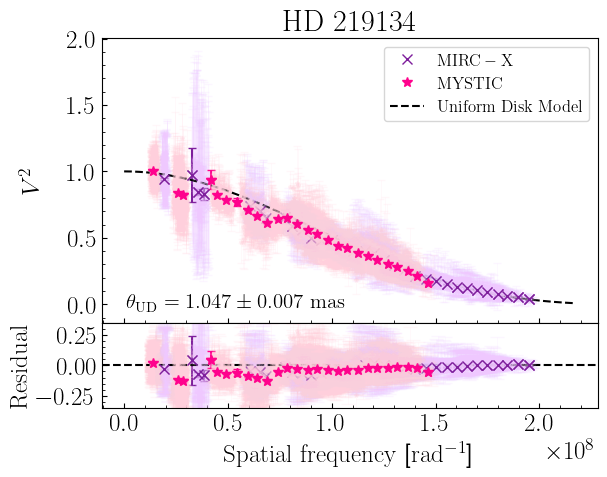

(<Figure size 640x480 with 2 Axes>,
 (<Axes: title={'center': '$\\rm HD~219134$'}, ylabel='$V^2$'>,
  <Axes: xlabel='$\\rm Spatial$ $\\rm frequency$ [$\\rm rad^{-1}$]', ylabel='$\\rm Residual$'>))

In [21]:
plot_v2_fit(
    data_dict=data_dict,
    star=star,        
    datasets_to_plot=['mircx', 'mystic'],
    to_bin = ['mircx', 'mystic'],
    plot_udmodel = True,
    title = rf'$\rm HD~219134$',
    #set_axis= [-0.05, 5e8, -0.05, 1.1],
    eq_text=True,
    show = True
    )

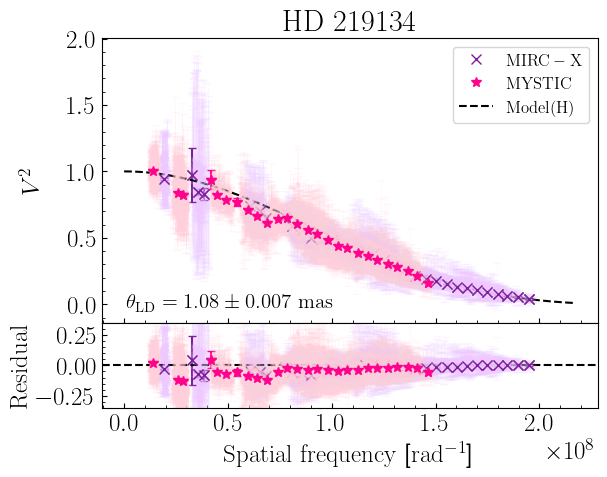

(<Figure size 640x480 with 2 Axes>,
 (<Axes: title={'center': '$\\rm HD~219134$'}, ylabel='$V^2$'>,
  <Axes: xlabel='$\\rm Spatial$ $\\rm frequency$ [$\\rm rad^{-1}$]', ylabel='$\\rm Residual$'>))

In [23]:
plot_v2_fit(
    data_dict=data_dict,
    star=star,        
    datasets_to_plot=['mircx', 'mystic'],
    to_bin = ['mircx', 'mystic'],
    ldc_band = 'ldc_H',
    plot_ldmodel = True,
    title = rf'$\rm HD~219134$',
    #set_axis= [-0.05, 5e8, -0.05, 1.1],
    eq_text=True,
    show = True
    )